# Knowledge graph experiment data generation

### For robustness examples, separate ro patterns in the query examples of training sets and validation sets. Still train all ro patterns in query in fact only training sets.

In [27]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import trange

In [28]:
n_nodes = 50
n_relations = 5

node_vocab = [f'N{i}' for i in range(n_nodes)]
relation_vocab = [f'R{i}' for i in range(n_relations)]
special_tokens = ['<CTX>', '</CTX>', '<SEP>', '<QUERY>', '</QUERY>', '<EOS>', '<PAD>', '<UNK>']
vocab = node_vocab + relation_vocab + special_tokens
vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_vocab = {idx: word for word, idx in vocab_to_idx.items()}

([50, 50, 50, 50, 50], [25, 22, 27, 22, 23])


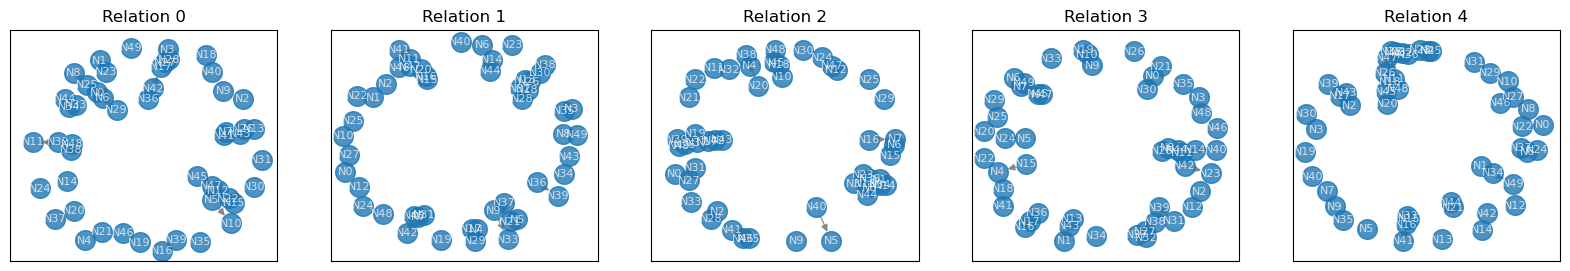

In [29]:
# randomly generate a graph with unique object for each (subject, relation) pair

def generate_graph(n_nodes, n_relations, p=1):
    graphs = [nx.DiGraph() for _ in range(n_relations)]
    for i in range(len(graphs)):
        graph = graphs[i]
        graph.add_nodes_from(node_vocab)
        for node in node_vocab:
            if np.random.rand() < p:
            # remove self loops
                obj_node = np.random.choice(node_vocab)
                if node != obj_node:
                    graph.add_edge(node, obj_node, relation=f'R{i}')
    return graphs

def draw_graph(graphs):    
    fig, axs = plt.subplots(ncols=n_relations, figsize=(4*n_relations,3))
    options = {"edge_color": "tab:gray", "node_size": 200, "alpha": 0.8, "node_color": "tab:blue", "font_color": "whitesmoke", "font_size": 8}
    for rel in range(n_relations):
        pos = nx.spring_layout(graphs[rel])
        
        nx.draw_networkx(graphs[rel], pos=pos, **options, ax=axs[rel])
        axs[rel].set_title(f"Relation {rel}")
    
graphs = generate_graph(50, n_relations, p=.5)
draw_graph(graphs)

# graph information
def get_graph_info(graphs):
    n_edges = [graph.number_of_edges() for graph in graphs]
    n_nodes = [graph.number_of_nodes() for graph in graphs]
    return n_nodes, n_edges
print(get_graph_info(graphs))


In [30]:
facts = {rel: list(graphs[rel].edges) for rel in range(n_relations)}
facts_all = [[fact[0], f'R{rel}', fact[1]] for rel in facts for fact in facts[rel]]

    

# generate context of true but irrelevant facts
def generate_pure_fact_example(fact, return_idx=True):
    # first sample fact for query
    ctx_start = '<CTX>' if not return_idx else vocab_to_idx['<CTX>']
    ctx_end = '</CTX>' if not return_idx else vocab_to_idx['</CTX>']
    query_start = '<QUERY>' if not return_idx else vocab_to_idx['<QUERY>']
    query_end = '</QUERY>' if not return_idx else vocab_to_idx['</QUERY>']
    eos = '<EOS>' if not return_idx else vocab_to_idx['<EOS>']
    fact = [vocab_to_idx[word] for word in fact] if return_idx else fact

    sequence = [ctx_start]

    sequence += [ctx_end, query_start]
    sequence += fact
    sequence += [query_end, eos]

    if not return_idx:
        return ' '.join(sequence)

    return sequence

print(generate_pure_fact_example(facts_all[0], False))
facts_all = [generate_pure_fact_example(fact, True) for fact in facts_all]
print("Number of total facts:", len(facts_all))
print([idx_to_vocab[idx] for idx in facts_all[0]])


<CTX> </CTX> <QUERY> N0 R0 N25 </QUERY> <EOS>
Number of total facts: 119
['<CTX>', '</CTX>', '<QUERY>', 'N0', 'R0', 'N25', '</QUERY>', '<EOS>']


In [31]:
# Take 60% of ro patterns for queries in training, save the rest for validation sets
from collections import defaultdict
facts_query_train = defaultdict(list)
facts_query_val = defaultdict(list)
for rel in range(n_relations):
    for edge in list(graphs[rel].edges):
        if np.random.rand() < .6:
            facts_query_train[rel].append(edge) 
        else:
            facts_query_val[rel].append(edge)

facts_all_query_train = [[fact[0], f'R{rel}', fact[1]] for rel in facts_query_train for fact in facts_query_train[rel]]

print(facts_all_query_train)
print(facts_query_val)
print(facts_query_train)
print("Number of total facts:", len(facts_all))
print("number of facts used in query for training:", len(facts_all_query_train))

[['N6', 'R0', 'N25'], ['N15', 'R0', 'N22'], ['N17', 'R0', 'N27'], ['N22', 'R0', 'N15'], ['N23', 'R0', 'N1'], ['N25', 'R0', 'N8'], ['N26', 'R0', 'N13'], ['N27', 'R0', 'N3'], ['N32', 'R0', 'N11'], ['N33', 'R0', 'N44'], ['N42', 'R0', 'N17'], ['N43', 'R0', 'N26'], ['N47', 'R0', 'N22'], ['N3', 'R1', 'N35'], ['N4', 'R1', 'N17'], ['N5', 'R1', 'N21'], ['N7', 'R1', 'N45'], ['N9', 'R1', 'N33'], ['N11', 'R1', 'N41'], ['N13', 'R1', 'N38'], ['N17', 'R1', 'N29'], ['N28', 'R1', 'N18'], ['N36', 'R1', 'N39'], ['N37', 'R1', 'N21'], ['N44', 'R1', 'N14'], ['N45', 'R1', 'N42'], ['N47', 'R1', 'N41'], ['N1', 'R2', 'N14'], ['N3', 'R2', 'N13'], ['N7', 'R2', 'N6'], ['N10', 'R2', 'N18'], ['N13', 'R2', 'N34'], ['N17', 'R2', 'N37'], ['N23', 'R2', 'N1'], ['N34', 'R2', 'N1'], ['N36', 'R2', 'N14'], ['N37', 'R2', 'N49'], ['N40', 'R2', 'N5'], ['N42', 'R2', 'N17'], ['N45', 'R2', 'N48'], ['N5', 'R3', 'N24'], ['N7', 'R3', 'N49'], ['N8', 'R3', 'N44'], ['N10', 'R3', 'N19'], ['N13', 'R3', 'N1'], ['N14', 'R3', 'N40'], ['N16',

In [32]:
def sample_fact(return_idx=False):
    # sample relation
    rel = np.random.randint(n_relations)
    # sample fact
    fact_idx = np.random.choice(len(facts[rel]))
    fact = facts[rel][fact_idx]
    n1, n2 = fact
    if return_idx:
        return [vocab_to_idx[n1], vocab_to_idx[f'R{rel}'], vocab_to_idx[n2]]

    return [n1, f'R{rel}', n2]

def sample_query_robust(return_idx=False, phase="train"): # phase = train or val
    # Take part of ro patterns for queries in training, save the rest for validation sets
    # sample relation
    rel = np.random.randint(n_relations)
    # sample fact
    if phase == "train":
        fact_idx = np.random.choice(len(facts_query_train[rel]))
        fact = facts_query_train[rel][fact_idx]
    else:
        fact_idx = np.random.choice(len(facts_query_val[rel]))
        fact = facts_query_val[rel][fact_idx]

    n1, n2 = fact
    if return_idx:
        return [vocab_to_idx[n1], vocab_to_idx[f'R{rel}'], vocab_to_idx[n2]]

    return [n1, f'R{rel}', n2]


def sample_falsehood(return_idx=False):
    # sample relation
    rel = np.random.randint(n_relations)

    while True:
        # sample falsehood
        n1, n2 = np.random.choice(node_vocab, size=2)
        if (n1, n2) not in facts[rel]:
            break

    if return_idx:
        return [vocab_to_idx[n1], vocab_to_idx[f'R{rel}'], vocab_to_idx[n2]]

    return [n1, f'R{rel}', n2]


In [33]:
# generate context of true but irrelevant facts
def generate_robustness_example(context_length, return_idx=False, phase='train'):
    # first sample fact for query
    ctx_start = '<CTX>' if not return_idx else vocab_to_idx['<CTX>']
    ctx_end = '</CTX>' if not return_idx else vocab_to_idx['</CTX>']
    sep = '<SEP>' if not return_idx else vocab_to_idx['<SEP>']
    query_start = '<QUERY>' if not return_idx else vocab_to_idx['<QUERY>']
    query_end = '</QUERY>' if not return_idx else vocab_to_idx['</QUERY>']
    eos = '<EOS>' if not return_idx else vocab_to_idx['<EOS>']

    sequence = [ctx_start]
    query_fact = sample_query_robust(return_idx=return_idx, phase=phase)

    for i in range(context_length):
        # NOTE: for now, not checking if irrelevant; sampling randomly so most likely irrelevant
        ctx_fact = sample_fact(return_idx=return_idx)
        sequence += ctx_fact
        sequence += [sep]

    sequence += [ctx_end, query_start]

    sequence += query_fact
    sequence += [query_end, eos]

    if not return_idx:
        return ' '.join(sequence)

    return sequence


In [34]:
# print some examples of robustness examples
for _ in range(5):
    print(generate_robustness_example(3, return_idx=False, phase='val'))

<CTX> N15 R0 N22 <SEP> N13 R3 N1 <SEP> N44 R1 N14 <SEP> </CTX> <QUERY> N43 R3 N1 </QUERY> <EOS>
<CTX> N38 R0 N48 <SEP> N47 R3 N49 <SEP> N38 R4 N32 <SEP> </CTX> <QUERY> N38 R4 N32 </QUERY> <EOS>
<CTX> N11 R1 N41 <SEP> N36 R2 N14 <SEP> N16 R1 N11 <SEP> </CTX> <QUERY> N8 R2 N34 </QUERY> <EOS>
<CTX> N7 R1 N45 <SEP> N32 R1 N38 <SEP> N10 R3 N19 <SEP> </CTX> <QUERY> N39 R2 N49 </QUERY> <EOS>
<CTX> N20 R2 N38 <SEP> N31 R1 N7 <SEP> N15 R4 N41 <SEP> </CTX> <QUERY> N39 R2 N49 </QUERY> <EOS>


In [35]:
# query is inconsistent with world knowledge
def generate_controllability_example(context_length, insert_pos=None, return_idx=False):
    # first sample fact for query
    ctx_start = '<CTX>' if not return_idx else vocab_to_idx['<CTX>']
    ctx_end = '</CTX>' if not return_idx else vocab_to_idx['</CTX>']
    sep = '<SEP>' if not return_idx else vocab_to_idx['<SEP>']
    query_start = '<QUERY>' if not return_idx else vocab_to_idx['<QUERY>']
    query_end = '</QUERY>' if not return_idx else vocab_to_idx['</QUERY>']
    eos = '<EOS>' if not return_idx else vocab_to_idx['<EOS>']

    sequence = [ctx_start]

    query_fact = sample_falsehood(return_idx=return_idx)

    contexts = []
    for i in range(context_length-1):
        ctx_fact = sample_fact(return_idx=return_idx)
        contexts.append(ctx_fact)

    # insert query fact at random position of context to test controllability
    if insert_pos is None:
        insert_pos = np.random.randint(context_length)
    contexts.insert(insert_pos, query_fact)

    for ctx_fact in contexts:
        sequence += ctx_fact
        sequence += [sep]

    sequence += [ctx_end, query_start]

    sequence += query_fact
    sequence += [query_end, eos]

    if not return_idx:
        return ' '.join(sequence)

    return sequence


In [36]:
# print some examples of robustness examples
for _ in range(5):
    print(generate_controllability_example(3, return_idx=False))

<CTX> N23 R1 N30 <SEP> N17 R1 N29 <SEP> N18 R1 N26 <SEP> </CTX> <QUERY> N23 R1 N30 </QUERY> <EOS>
<CTX> N47 R3 N49 <SEP> N43 R3 N13 <SEP> N25 R0 N8 <SEP> </CTX> <QUERY> N43 R3 N13 </QUERY> <EOS>
<CTX> N18 R1 N5 <SEP> N3 R1 N35 <SEP> N9 R3 N10 <SEP> </CTX> <QUERY> N18 R1 N5 </QUERY> <EOS>
<CTX> N41 R0 N0 <SEP> N7 R3 N49 <SEP> N3 R2 N13 <SEP> </CTX> <QUERY> N41 R0 N0 </QUERY> <EOS>
<CTX> N31 R2 N0 <SEP> N40 R3 N44 <SEP> N20 R2 N38 <SEP> </CTX> <QUERY> N40 R3 N44 </QUERY> <EOS>


In [37]:
# print some examples of robustness examples (print token idx)
for _ in range(5):
    print(generate_controllability_example(3, return_idx=True))

[55, 47, 50, 22, 57, 45, 51, 42, 57, 22, 54, 8, 57, 56, 58, 22, 54, 8, 59, 60]
[55, 49, 53, 6, 57, 27, 52, 8, 57, 18, 54, 47, 57, 56, 58, 27, 52, 8, 59, 60]
[55, 34, 50, 42, 57, 27, 50, 3, 57, 47, 50, 22, 57, 56, 58, 34, 50, 42, 59, 60]
[55, 30, 54, 39, 57, 44, 51, 14, 57, 31, 52, 0, 57, 56, 58, 30, 54, 39, 59, 60]
[55, 6, 53, 19, 57, 16, 54, 41, 57, 37, 54, 24, 57, 56, 58, 6, 53, 19, 59, 60]


In [38]:
# pre-training: "robustness" context_length=0

# training
# w.p. 1/3
# just facts: "robustness" with context_length=0
# w.p. 1/3
# robustness: uniformly context_length=1,2,3
# w.p. 1/3
# controllability: uniformly context_length=1,2,3

# validation
# same but separate context_lengths to different datasets to compute separate metrics

In [39]:
def pad_truncate(sequence, max_length):
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    elif len(sequence) < max_length:
        sequence += [vocab_to_idx['<PAD>']] * (max_length - len(sequence))

    return sequence

## Create training dataset

In [40]:
# create train_ds
n_examples = 3000 # total number of examples

p_facts = 1/3 # proportion of facts
p_robustness = 1/3 # proportion of robustness
p_controllability = 1/3 # proportion of controllability
assert (p_facts + p_robustness + p_controllability) == 1 # make sure this makes sense

max_context_statements = 3 # maximum number of context facts; sample uniformly from 1,2,3
max_block_length = len(generate_robustness_example(3, return_idx=True)) # get the block length of the longest example

n_facts = int(n_examples * p_facts)
n_robustness = int(n_examples * p_robustness)
n_controllability = int(n_examples * p_controllability)

In [41]:
# create pure fact train_ds_fact for pretraining
max_length = len(facts_all[0]) # get the block length of the longest example

train_data_fact = [pad_truncate(fact, max_length) for fact in facts_all]
print(len(train_data_fact))
train_data_fact

119


[[55, 56, 58, 0, 50, 25, 59, 60],
 [55, 56, 58, 5, 50, 10, 59, 60],
 [55, 56, 58, 6, 50, 25, 59, 60],
 [55, 56, 58, 7, 50, 26, 59, 60],
 [55, 56, 58, 12, 50, 15, 59, 60],
 [55, 56, 58, 15, 50, 22, 59, 60],
 [55, 56, 58, 17, 50, 27, 59, 60],
 [55, 56, 58, 22, 50, 15, 59, 60],
 [55, 56, 58, 23, 50, 1, 59, 60],
 [55, 56, 58, 25, 50, 8, 59, 60],
 [55, 56, 58, 26, 50, 13, 59, 60],
 [55, 56, 58, 27, 50, 3, 59, 60],
 [55, 56, 58, 28, 50, 3, 59, 60],
 [55, 56, 58, 29, 50, 6, 59, 60],
 [55, 56, 58, 32, 50, 11, 59, 60],
 [55, 56, 58, 33, 50, 44, 59, 60],
 [55, 56, 58, 34, 50, 33, 59, 60],
 [55, 56, 58, 36, 50, 42, 59, 60],
 [55, 56, 58, 38, 50, 48, 59, 60],
 [55, 56, 58, 41, 50, 26, 59, 60],
 [55, 56, 58, 42, 50, 17, 59, 60],
 [55, 56, 58, 43, 50, 26, 59, 60],
 [55, 56, 58, 45, 50, 47, 59, 60],
 [55, 56, 58, 47, 50, 22, 59, 60],
 [55, 56, 58, 48, 50, 11, 59, 60],
 [55, 56, 58, 3, 51, 35, 59, 60],
 [55, 56, 58, 4, 51, 17, 59, 60],
 [55, 56, 58, 5, 51, 21, 59, 60],
 [55, 56, 58, 7, 51, 45, 59, 60]

In [42]:
train_data = []

for _ in trange(n_facts):
    example = generate_robustness_example(0, return_idx=True)
    example = pad_truncate(example, max_block_length)
    train_data.append(example)

for _ in trange(n_robustness):
    n_context_statements = np.random.randint(1, max_context_statements+1)
    example = generate_robustness_example(n_context_statements, return_idx=True, phase='train')
    example = pad_truncate(example, max_block_length)
    train_data.append(example)

for _ in trange(n_controllability):
    n_context_statements = np.random.randint(1, max_context_statements+1)
    insert_pos = np.random.randint(n_context_statements)
    example = generate_controllability_example(n_context_statements, insert_pos=insert_pos, return_idx=True)
    example = pad_truncate(example, max_block_length)
    train_data.append(example)


100%|██████████| 1000/1000 [00:00<00:00, 24948.72it/s]


In [43]:
# create and save
train_ds_tensor = torch.tensor(train_data, dtype=torch.int64)
# np.random.shuffle(train_ds)
torch.save(train_ds_tensor, '../data/knowledge_graph_sep_ro/knowledge_graph_train_ds.pt')

train_ds_fact_tensor = torch.tensor(train_data_fact, dtype=torch.int64)
torch.save(train_ds_fact_tensor, '../data/knowledge_graph_sep_ro/knowledge_graph_train_ds_fact.pt')

In [44]:
train_ds_tensor = torch.load('../data/knowledge_graph_sep_ro/knowledge_graph_train_ds.pt')
train_ds_fact_tensor = torch.load('../data/knowledge_graph_sep_ro/knowledge_graph_train_ds_fact.pt')
for x in train_ds_tensor:
    print(x)

tensor([55, 56, 58, 26, 54, 47, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
        61, 61])
tensor([55, 56, 58, 47, 54, 23, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
        61, 61])
tensor([55, 56, 58, 45, 54, 26, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
        61, 61])
tensor([55, 56, 58, 45, 51, 42, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
        61, 61])
tensor([55, 56, 58, 33, 54, 41, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
        61, 61])
tensor([55, 56, 58, 14, 53, 40, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
        61, 61])
tensor([55, 56, 58, 44, 54, 21, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
        61, 61])
tensor([55, 56, 58, 13, 52, 34, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
        61, 61])
tensor([55, 56, 58,  3, 51, 35, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
        61, 61])
tensor([55, 56, 58, 21, 54, 44, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
        61, 61])
tensor([55, 56, 58, 36, 52, 14

In [45]:
def generate_val_data(type, n_context_statements, n_examples, max_block_length=max_block_length):
    example_generator = generate_robustness_example if type == 'robustness' else generate_controllability_example
    val_data = []
    for _ in trange(n_examples):
        if type == 'robustness':
            example = generate_robustness_example(n_context_statements, return_idx=True, phase='val')
        else:
            example = example_generator(n_context_statements, return_idx=True)
        example = pad_truncate(example, max_block_length)
        val_data.append(example)

    return torch.tensor(val_data)


In [46]:
for type in ['robustness', 'controllability']:
    for n_context_statements in range(1, max_context_statements+1):
        n_examples = 1_000
        val_data = generate_val_data(type, n_context_statements, n_examples)
        torch.save(val_data, f'../data/knowledge_graph_sep_ro/knowledge_graph_val_ds_{type}_{n_context_statements}.pt')

100%|██████████| 1000/1000 [00:00<00:00, 19725.09it/s]


### Demo on how to load data

In [47]:
# how to load data and createe data loader
import sys; sys.path.append('../')
from data_utils import LanguageModelTensorDataset
train_ds = LanguageModelTensorDataset(train_ds_tensor)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)

In [48]:
# some examples from train_ds_tensor
for x in train_ds_tensor[:100]:
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    print()

[55, 56, 58, 26, 54, 47, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N26 R4 N47 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[55, 56, 58, 47, 54, 23, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N47 R4 N23 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[55, 56, 58, 45, 54, 26, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N45 R4 N26 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[55, 56, 58, 45, 51, 42, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N45 R1 N42 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[55, 56, 58, 33, 54, 41, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N33 R4 N41 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

In [49]:
# some examples from train__ds_tensor
for x in train_ds_fact_tensor[:5]:
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    print()

[55, 56, 58, 0, 50, 25, 59, 60]
<CTX> </CTX> <QUERY> N0 R0 N25 </QUERY> <EOS>

[55, 56, 58, 5, 50, 10, 59, 60]
<CTX> </CTX> <QUERY> N5 R0 N10 </QUERY> <EOS>

[55, 56, 58, 6, 50, 25, 59, 60]
<CTX> </CTX> <QUERY> N6 R0 N25 </QUERY> <EOS>

[55, 56, 58, 7, 50, 26, 59, 60]
<CTX> </CTX> <QUERY> N7 R0 N26 </QUERY> <EOS>

[55, 56, 58, 12, 50, 15, 59, 60]
<CTX> </CTX> <QUERY> N12 R0 N15 </QUERY> <EOS>



In [50]:
# some examples from train_dl
train_iter = iter(train_dl)
for _ in range(5):
    # get next from train_dl
    x, y = next(train_iter)
    x, y = x.squeeze(), y.squeeze()
    print('INPUT')
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    print('TARGET')
    print(y.tolist())
    print(' '.join([vocab[idx] for idx in y]))
    print('-'*100)
    print()

INPUT
[55, 46, 52, 46, 57, 46, 54, 27, 57, 37, 51, 21, 57, 56, 58, 46, 52, 46, 59]
<CTX> N46 R2 N46 <SEP> N46 R4 N27 <SEP> N37 R1 N21 <SEP> </CTX> <QUERY> N46 R2 N46 </QUERY>
TARGET
[46, 52, 46, 57, 46, 54, 27, 57, 37, 51, 21, 57, 56, 58, 46, 52, 46, 59, 60]
N46 R2 N46 <SEP> N46 R4 N27 <SEP> N37 R1 N21 <SEP> </CTX> <QUERY> N46 R2 N46 </QUERY> <EOS>
----------------------------------------------------------------------------------------------------

INPUT
[55, 56, 58, 37, 52, 49, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N37 R2 N49 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
TARGET
[56, 58, 37, 52, 49, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
</CTX> <QUERY> N37 R2 N49 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
----------------------------------------------------------------------------------------------------

INPUT
[55, 56, 58, 47, 50, 22, 59, 60, 61, 61, 61, 6